In [71]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
from math import * 


print("The current directory is: ")
print(os.getcwd())
if not os.getcwd().endswith("Abaqus-TDS-Hydrogen-Bayesian-Optimization"):
    # Move up two directories
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
print("The current directory is: ")
print(os.getcwd())

from utils.IO import *
from utils.calculation import *

The current directory is: 
c:\LocalUserData\User-data\nguyenb5\Abaqus-TDS-Hydrogen-Bayesian-Optimization
The current directory is: 
c:\LocalUserData\User-data\nguyenb5\Abaqus-TDS-Hydrogen-Bayesian-Optimization


In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from configs.chosen_project import *
from src.stage1_global_configs import *

chosen_project_path = "configs/global_config_CP1000_RD_20C.json"

global_configs = main_global_configs(chosen_project_path)

all_paths = global_configs['all_paths']


START RUNNING FROM *** 2024-11-15 19:13:57 ***

= Stage 1: Loading configs and all paths =

Welcome to Abaqus Seq2Seq flow curve calibration project

The configurations you have chosen: 

+--------------------------+-------------------------------------------------------------------------------+
|      Global Configs      |                                  User choice                                  |
+--------------------------+-------------------------------------------------------------------------------+
|       PROJECT_PATH       | c:\LocalUserData\User-data\nguyenb5\Abaqus-TDS-Hydrogen-Bayesian-Optimization |
|         LOG_PATH         |                               log/CP1000_RD_20C                               |
|  RESULTS_INIT_DATA_PATH  |                       results_initial_data/CP1000_RD_20C                      |
| RESULTS_INIT_COMMON_PATH |                      results_initial_common/CP1000_RD_20C                     |
|  RESULTS_ITER_DATA_PATH  |                    

In [74]:
from utils.hardening_laws import *

results_init_common_path = all_paths['results_init_common_path']
results_init_data_path = all_paths['results_init_data_path']
targets_path = all_paths['targets_path']
num_measurements = global_configs['num_measurements']
param_config = global_configs['param_config']

In [75]:
# Define a function to denormalize a point
def denormalize_point(normalized_point, param_config):
    """
    normalized_point: np.array of shape (num_params)
    param_config: dictionary of parameter configurations from .json file in configs folder
    """
    denormalized_point = []
    for i, param_key in enumerate(param_config.keys()):
        param_multiplier = param_config[param_key]["exponent"]
        param_min = param_config[param_key]["lower"] * param_multiplier
        param_max = param_config[param_key]["upper"] * param_multiplier
        # Denormalize each value
        denormalized_value = normalized_point[i] * (param_max - param_min) + param_min
        denormalized_point.append(denormalized_value)
    return np.array(denormalized_point)

def denormalize_points(normalized_points, param_config):
    """
    normalized_points: np.array of shape (num_points, num_params)
    param_config: dictionary of parameter configurations from .json file in configs folder
    """
    denormalized_points = []
    for i in range(normalized_points.shape[0]):
        denormalized_point = denormalize_point(normalized_points[i], param_config)
        denormalized_points.append(denormalized_point)
    return np.array(denormalized_points)

# Define a function to normalize a point
def normalize_point(denormalized_point, param_config):
    """
    denormalized_point: np.array of shape (num_params)
    param_config: dictionary of parameter configurations from .json file in configs folder
    """
    normalized_point = []
    for i, param_key in enumerate(param_config.keys()):
        param_multiplier = param_config[param_key]["exponent"]
        param_min = param_config[param_key]["lower"] * param_multiplier
        param_max = param_config[param_key]["upper"] * param_multiplier
        # Normalize each value
        normalized_value = (denormalized_point[i] - param_min) / (param_max - param_min)
        normalized_point.append(normalized_value)
    return np.array(normalized_point)

def normalize_points(denormalized_points, param_config):
    """
    denormalized_points: np.array of shape (num_points, num_params)
    param_config: dictionary of parameter configurations from .json file in configs folder
    """
    normalized_points = []
    for i in range(denormalized_points.shape[0]):
        normalized_point = normalize_point(denormalized_points[i], param_config)
        normalized_points.append(normalized_point)
    return np.array(normalized_points)

In [76]:
# Loading the TDS_measurements.npy
sim_TDS_measurements = np.load(f"{results_init_common_path}/TDS_measurements.npy", allow_pickle=True).tolist()

features_unnormalized_array = []

for index, param_key in enumerate(param_config.keys()):
    param_values_list = np.array([params_tuple[index][1] for params_tuple in sim_TDS_measurements.keys()])
    features_unnormalized_array.append(param_values_list)

features_unnormalized_array = np.array(features_unnormalized_array).T

target_TDS_measurements = {}

df = pd.read_excel(f'{targets_path}/measurements.xlsx', engine='openpyxl')
time_TDS = df['time'].to_numpy()
C_wtppm = df['C_wtppm'].to_numpy()
C_mol = df['C_mol'].to_numpy()

for num_measurement in range(num_measurements):
    target_TDS_measurements[f"measurement_{num_measurement + 1}"] = {
        "time": time_TDS[num_measurement],
        "C_wtppm": C_wtppm[num_measurement],
        "C_mol": C_mol[num_measurement]
    }

MAE_list = []

# Calculate the known MAE when H_surface = 0
known_mae = sum(target_TDS_measurements[f"measurement_{i + 1}"]["C_mol"] for i in range(num_measurements))

for params_tuple, sim_measurements in sim_TDS_measurements.items():
    current_MAE = 0
    for sim_measurement in sim_measurements.values():
        sim_measurement_time = sim_measurement["time"]
        for target_measurement in target_TDS_measurements.values():
            target_measurement_time = target_measurement["time"]
            if sim_measurement_time == target_measurement_time:
                current_MAE += abs(sim_measurement["C_mol"] - target_measurement["C_mol"])
                break
    MAE_list.append(current_MAE/num_measurements)

label_array = np.array(MAE_list)


# Now we need to normalize the features_unnormalized_array and label_array

features_normalized_array = normalize_points(features_unnormalized_array, param_config)

print("Shape of features_normalized_array:")
print(features_normalized_array.shape)
print("Shape of features_unnormalized_array:")
print(features_unnormalized_array.shape)
print("Shape of label_array:")
print(label_array.shape)

print("Unnormalized features_unnormalized_array:")
print(features_unnormalized_array)
print("Unnormalized label_array:")
print(label_array)

# The normalized array should be a sobol sequence since the unnormalized array is sampled from a sobol sequence
print("Normalized features_normalized_array:")
print(features_normalized_array)

Shape of features_normalized_array:
(32, 2)
Shape of features_unnormalized_array:
(32, 2)
Shape of label_array:
(32,)
Unnormalized features_unnormalized_array:
[[5.60000000e+00 1.00000000e-11]
 [7.97500000e+00 5.05000000e-10]
 [9.16250000e+00 2.57500000e-10]
 [6.78750000e+00 7.52500000e-10]
 [7.38125000e+00 3.81250000e-10]
 [9.75625000e+00 8.76250000e-10]
 [8.56875000e+00 1.33750000e-10]
 [6.19375000e+00 6.28750000e-10]
 [6.49062500e+00 3.19375000e-10]
 [8.86562500e+00 8.14375000e-10]
 [1.00531250e+01 7.18750000e-11]
 [7.67812500e+00 5.66875000e-10]
 [7.08437500e+00 1.95625000e-10]
 [9.45937500e+00 6.90625000e-10]
 [8.27187500e+00 4.43125000e-10]
 [5.89687500e+00 9.38125000e-10]
 [6.04531250e+00 4.74062500e-10]
 [8.42031250e+00 9.69062500e-10]
 [9.60781250e+00 2.26562500e-10]
 [7.23281250e+00 7.21562500e-10]
 [7.82656250e+00 1.02812500e-10]
 [1.02015625e+01 5.97812500e-10]
 [9.01406250e+00 3.50312500e-10]
 [6.63906250e+00 8.45312500e-10]
 [6.34218750e+00 1.64687500e-10]
 [8.71718750e+0

In [77]:
import numpy as np

# Known MAE when H_surface = 0
known_mae = sum(target_TDS_measurements[f"measurement_{i + 1}"]["C_mol"] 
    for i in range(num_measurements)) / num_measurements

# Create 11 evenly spaced DL values between 0 and 1 for H_surface = 0
DL_values = np.linspace(0, 1, 3)
H_surface_values = np.zeros_like(DL_values)  # H_surface fixed at 0

# Stack H_surface and DL values to create new feature points
features_augmented = np.column_stack((H_surface_values, DL_values))

# Create labels for these new points (all equal to known_mae)
labels_augmented = np.full((3,), known_mae)

# Concatenate these new points to the existing features and labels arrays
features_normalized_augmented = np.vstack((features_normalized_array, features_augmented))
label_array_augmented = np.concatenate((label_array, labels_augmented))

# Print the augmented arrays to verify
print("Augmented Features Array (features_normalized_augmented):")
print(features_normalized_augmented)
print("Augmented Labels Array (label_array_augmented):")
print(label_array_augmented)


Augmented Features Array (features_normalized_augmented):
[[0.      0.     ]
 [0.5     0.5    ]
 [0.75    0.25   ]
 [0.25    0.75   ]
 [0.375   0.375  ]
 [0.875   0.875  ]
 [0.625   0.125  ]
 [0.125   0.625  ]
 [0.1875  0.3125 ]
 [0.6875  0.8125 ]
 [0.9375  0.0625 ]
 [0.4375  0.5625 ]
 [0.3125  0.1875 ]
 [0.8125  0.6875 ]
 [0.5625  0.4375 ]
 [0.0625  0.9375 ]
 [0.09375 0.46875]
 [0.59375 0.96875]
 [0.84375 0.21875]
 [0.34375 0.71875]
 [0.46875 0.09375]
 [0.96875 0.59375]
 [0.71875 0.34375]
 [0.21875 0.84375]
 [0.15625 0.15625]
 [0.65625 0.65625]
 [0.90625 0.40625]
 [0.40625 0.90625]
 [0.28125 0.28125]
 [0.78125 0.78125]
 [0.53125 0.03125]
 [0.03125 0.53125]
 [0.      0.     ]
 [0.      0.5    ]
 [0.      1.     ]]
Augmented Labels Array (label_array_augmented):
[4.80127149 1.00980193 1.27396012 1.28866423 1.06375993 2.68939287
 0.61098821 1.60372377 1.48186064 1.69986183 0.81704117 0.97123486
 1.17015499 2.21539387 1.04387778 1.68295658 1.69871796 1.51672888
 1.51568986 1.08130945 1.12

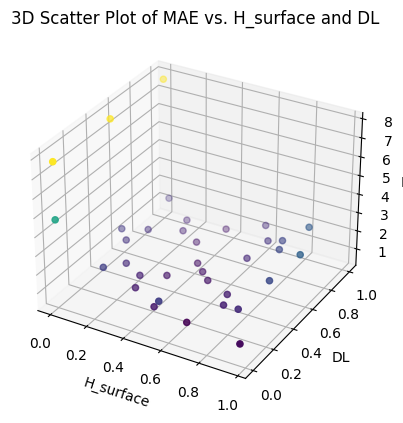

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
ax.scatter(features_normalized_augmented[:, 0], features_normalized_augmented[:, 1], label_array_augmented,
        c=label_array_augmented, cmap='viridis')
ax.set_xlabel('H_surface')
ax.set_ylabel('DL')
ax.set_zlabel('MAE')
ax.set_title('3D Scatter Plot of MAE vs. H_surface and DL')

plt.show()


In [79]:
import math
import torch

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

# Convert to PyTorch tensors
# Convert the augmented feature and label arrays to PyTorch tensors
train_X = torch.tensor(features_normalized_augmented, dtype=torch.float64, device=device)
train_Y = torch.tensor(label_array_augmented, dtype=torch.float64, device=device).unsqueeze(-1)  # Make sure train_Y is 2D for BoTorch

# Verify the shapes
print("train_X shape:", train_X.shape)  # Should be (number of samples, number of features)
print("train_Y shape:", train_Y.shape)  # Should be (number of samples, 1)

from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from botorch.models.transforms import Normalize
from gpytorch.kernels import RBFKernel, ScaleKernel, ConstantKernel, MaternKernel

# Define the kernel explicitly as an RBF kernel wrapped in a ScaleKernel
# If we dont set the ard_num_dims, the kernel will assume that all input dimensions have the same lengthscale
# It is known as an isotropic kernel

rbf_kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[1])) + ConstantKernel()
rbf_kernel.to(train_X)

GP_RBF_model = SingleTaskGP(train_X=train_X, train_Y=train_Y, 
                    train_Yvar = None,
                    likelihood = None,
                    covar_module=rbf_kernel)
GP_RBF_model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=GP_RBF_model.likelihood, model=GP_RBF_model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)

from torch.optim import Adam, SGD

NUM_EPOCHS = 40000

max_learning_rate = 0.0005
min_learning_rate = 0.0001

# Initialize optimizer with the maximum learning rate
optimizer = Adam([{'params': GP_RBF_model.parameters()}], lr=max_learning_rate)

# Calculate the decrement step for the learning rate
lr_decrement = (max_learning_rate - min_learning_rate) / NUM_EPOCHS

GP_RBF_model.train()

# Hyperparameters in the Multidimensional RBF Kernel
# In the multidimensional case, the RBF kernel has:
# One output scale parameter sigma for the entire kernel, which controls the overall variance of the function values.
# One lengthscale parameter per dimension controls the smoothness in the i-th input dimension.

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = GP_RBF_model(train_X)
    # Compute negative marginal log likelihood
    loss = - mll(output, GP_RBF_model.train_targets)
    # back prop gradients
    loss.backward()
    # print every 2000 iterations
    if (epoch + 1) % 2000 == 0:
        # Retrieve lengthscale, noise, and output scale for tracking
        scale_kernel = list(GP_RBF_model.covar_module.sub_kernels())[0]
        rbf_kernel = list(GP_RBF_model.covar_module.sub_kernels())[1]
        # rbf_kernel is also scale_kernel.base_kernel
        constant_kernel = list(GP_RBF_model.covar_module.sub_kernels())[2]
        lengthscales = rbf_kernel.lengthscale.tolist()[0]
        noise = GP_RBF_model.likelihood.noise.tolist()
        sigma = math.sqrt(scale_kernel.outputscale.item())  # Compute σ from σ^2
        constant_value = constant_kernel.constant.item()     # Get the optimized constant value
        
        # Print kernel parameters
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} ",
            f"lengthscale: {[round(ls, 6) for ls in lengthscales]} ",
            f"noise: {[round(n, 6) for n in noise]} ",
            f"sigma: {round(sigma, 6)} ",
            f"constant: {round(constant_value, 6)}"
        )

    # Update optimizer learning rate linearly
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(min_learning_rate, max_learning_rate - lr_decrement * epoch)

    optimizer.step()

train_X shape: torch.Size([35, 2])
train_Y shape: torch.Size([35, 1])
Epoch 2000/40000 - Loss: 1.338  lengthscale: [0.32754, 1.318354]  noise: [0.360228]  sigma: 1.126693  constant: 0.269181
Epoch 4000/40000 - Loss: 1.219  lengthscale: [0.158945, 2.113651]  noise: [0.228639]  sigma: 1.331676  constant: 0.122442
Epoch 6000/40000 - Loss: 1.154  lengthscale: [0.081693, 2.79248]  noise: [0.149143]  sigma: 1.305599  constant: 0.057457
Epoch 8000/40000 - Loss: 1.137  lengthscale: [0.058925, 3.179632]  noise: [0.143382]  sigma: 1.013089  constant: 0.025422
Epoch 10000/40000 - Loss: 1.110  lengthscale: [0.030768, 3.359173]  noise: [0.127117]  sigma: 0.716629  constant: 0.010704
Epoch 12000/40000 - Loss: 1.104  lengthscale: [0.023458, 3.381591]  noise: [0.125151]  sigma: 0.627666  constant: 0.004911
Epoch 14000/40000 - Loss: 1.103  lengthscale: [0.022857, 3.382676]  noise: [0.124999]  sigma: 0.622082  constant: 0.002708
Epoch 16000/40000 - Loss: 1.102  lengthscale: [0.022647, 3.369839]  noise: 

In [80]:
import math
import torch

# Use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

# Convert the augmented feature and label arrays to PyTorch tensors
train_X = torch.tensor(features_normalized_augmented, dtype=torch.float64, device=device)
train_Y = torch.tensor(label_array_augmented, dtype=torch.float64, device=device).unsqueeze(-1)  # Make sure train_Y is 2D for BoTorch

# Verify the shapes
print("train_X shape:", train_X.shape)  # Should be (number of samples, number of features)
print("train_Y shape:", train_Y.shape)  # Should be (number of samples, 1)

from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam

# Define the kernel as a Matern kernel wrapped in a ScaleKernel
# Setting `ard_num_dims` enables a separate lengthscale for each input dimension
matern_kernel = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=train_X.shape[1])) + ConstantKernel()
matern_kernel.to(train_X)

# Create the GP model with the Matern kernel
GP_Matern_model = SingleTaskGP(
    train_X=train_X, 
    train_Y=train_Y, 
    train_Yvar=None,
    likelihood=None,
    covar_module=matern_kernel
)
GP_Matern_model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

# Set up the marginal log likelihood
mll = ExactMarginalLogLikelihood(likelihood=GP_Matern_model.likelihood, model=GP_Matern_model)
mll = mll.to(train_X)

# Initialize optimizer with the maximum learning rate
NUM_EPOCHS = 40000
max_learning_rate = 0.0005
min_learning_rate = 0.0001
optimizer = Adam([{'params': GP_Matern_model.parameters()}], lr=max_learning_rate)

# Calculate the decrement step for the learning rate
lr_decrement = (max_learning_rate - min_learning_rate) / NUM_EPOCHS

GP_Matern_model.train()

# Training loop
for epoch in range(NUM_EPOCHS):
    # Clear gradients
    optimizer.zero_grad()
    # Forward pass through the model to obtain the output MultivariateNormal
    output = GP_Matern_model(train_X)
    # Compute negative marginal log likelihood
    loss = -mll(output, GP_Matern_model.train_targets)
    # Backprop gradients
    loss.backward()
    
    # Print parameters every 2000 iterations
    if (epoch + 1) % 2000 == 0:
        # Retrieve lengthscale, noise, and output scale for tracking
        scale_kernel = list(GP_Matern_model.covar_module.sub_kernels())[0]
        rbf_kernel = list(GP_Matern_model.covar_module.sub_kernels())[1]
        # rbf_kernel is also scale_kernel.base_kernel
        constant_kernel = list(GP_Matern_model.covar_module.sub_kernels())[2]
        lengthscales = rbf_kernel.lengthscale.tolist()[0]
        noise = GP_Matern_model.likelihood.noise.tolist()
        sigma = math.sqrt(scale_kernel.outputscale.item())  # Compute σ from σ^2
        constant_value = constant_kernel.constant.item()     # Get the optimized constant value
        
        # Print kernel parameters
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} ",
            f"lengthscale: {[round(ls, 6) for ls in lengthscales]} ",
            f"noise: {[round(n, 6) for n in noise]} ",
            f"sigma: {round(sigma, 6)} ",
            f"constant: {round(constant_value, 6)}"
        )

    # Update optimizer learning rate linearly
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(min_learning_rate, max_learning_rate - lr_decrement * epoch)

    optimizer.step()


train_X shape: torch.Size([35, 2])
train_Y shape: torch.Size([35, 1])
Epoch 2000/40000 - Loss: 1.325  lengthscale: [0.331324, 1.290388]  noise: [0.348238]  sigma: 1.118037  constant: 0.29884
Epoch 4000/40000 - Loss: 1.200  lengthscale: [0.155937, 2.046094]  noise: [0.199858]  sigma: 1.272188  constant: 0.138849
Epoch 6000/40000 - Loss: 1.142  lengthscale: [0.082336, 2.66727]  noise: [0.136157]  sigma: 1.08243  constant: 0.061628
Epoch 8000/40000 - Loss: 1.117  lengthscale: [0.047212, 3.026985]  noise: [0.126205]  sigma: 0.796596  constant: 0.0255
Epoch 10000/40000 - Loss: 1.106  lengthscale: [0.029978, 3.250881]  noise: [0.122792]  sigma: 0.655413  constant: 0.01105
Epoch 12000/40000 - Loss: 1.103  lengthscale: [0.027002, 3.473521]  noise: [0.123035]  sigma: 0.634323  constant: 0.005633
Epoch 14000/40000 - Loss: 1.102  lengthscale: [0.026506, 3.746814]  noise: [0.123735]  sigma: 0.629484  constant: 0.003186
Epoch 16000/40000 - Loss: 1.101  lengthscale: [0.026275, 4.026133]  noise: [0.1

In [88]:
# Define new test points in the normalized feature space
test_X = torch.tensor([
    [0.2, 0.5],  # Example new parameter combination in normalized space
    [0.7, 0.3]
], dtype=dtype, device=device)

# Set the model to evaluation mode
GP_RBF_model.eval()
with torch.no_grad():
    # Obtain the posterior distribution
    posterior = GP_RBF_model.posterior(test_X)
    mean = posterior.mean  # Predicted mean
    stddev = posterior.variance.sqrt()  # Predicted standard deviation (uncertainty)
    
print("Predicted mean MAE:", mean.cpu().numpy())
print("Predicted standard deviation (uncertainty):", stddev.cpu().numpy())


Predicted mean MAE: [[1.46154216]
 [1.57522501]]
Predicted standard deviation (uncertainty): [[0.61168665]
 [0.61960626]]


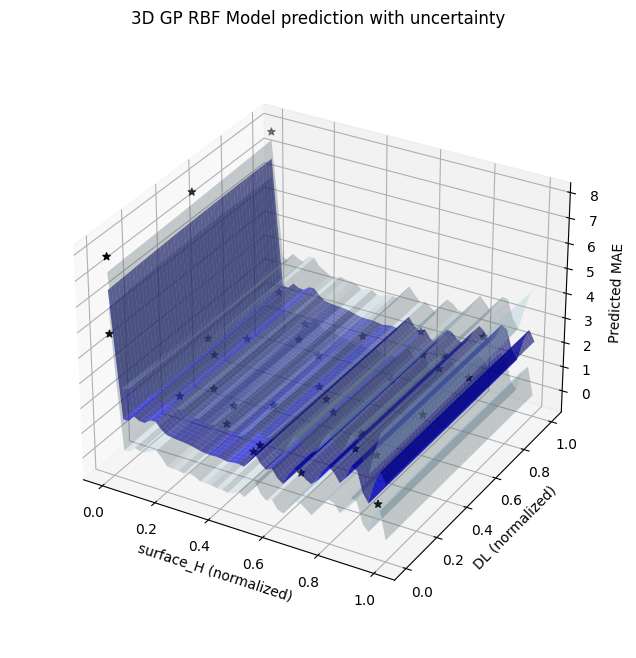

In [89]:
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt


# Create a 2D grid of points for prediction
x1 = np.linspace(0, 1, 50)  # Range for the first feature (surface_H)
x2 = np.linspace(0, 1, 50)  # Range for the second feature (DL)
X1, X2 = np.meshgrid(x1, x2)  # Create a grid
grid_X = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=dtype, device=device)

# Make predictions on the grid
GP_RBF_model.eval()
with torch.no_grad():
    posterior = GP_RBF_model.posterior(grid_X)
    mean = posterior.mean.cpu().numpy().reshape(50, 50)
    lower, upper = posterior.mvn.confidence_region()
    lower = lower.cpu().numpy().reshape(50, 50)
    upper = upper.cpu().numpy().reshape(50, 50)

# Plot the mean predictions as a 3D surface and the uncertainty as shading
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot for the mean
ax.plot_surface(X1, X2, mean, color='blue', alpha=0.6, rstride=1, cstride=1, edgecolor='none')

# Shaded area for the uncertainty
ax.plot_surface(X1, X2, upper, color='lightblue', alpha=0.3, rstride=1, cstride=1, edgecolor='none')
ax.plot_surface(X1, X2, lower, color='lightblue', alpha=0.3, rstride=1, cstride=1, edgecolor='none')

# Scatter plot of training data points
ax.scatter(train_X[:, 0].cpu().numpy(), train_X[:, 1].cpu().numpy(), train_Y.cpu().numpy(), color='black', marker='*', s=30)
ax.set_box_aspect(aspect=None, zoom=0.9)
# Labels
ax.set_xlabel("surface_H (normalized)")
ax.set_ylabel("DL (normalized)")
ax.set_zlabel("Predicted MAE")
ax.set_title("3D GP RBF Model prediction with uncertainty")

plt.show()

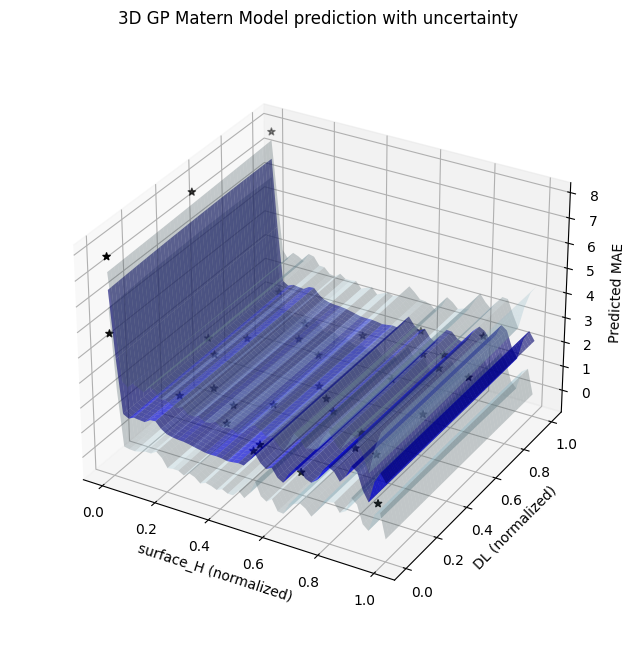

In [90]:
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt


# Create a 2D grid of points for prediction
x1 = np.linspace(0, 1, 50)  # Range for the first feature (surface_H)
x2 = np.linspace(0, 1, 50)  # Range for the second feature (DL)
X1, X2 = np.meshgrid(x1, x2)  # Create a grid
grid_X = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=dtype, device=device)

# Make predictions on the grid
GP_Matern_model.eval()
with torch.no_grad():
    posterior = GP_Matern_model.posterior(grid_X)
    mean = posterior.mean.cpu().numpy().reshape(50, 50)
    lower, upper = posterior.mvn.confidence_region()
    lower = lower.cpu().numpy().reshape(50, 50)
    upper = upper.cpu().numpy().reshape(50, 50)

# Plot the mean predictions as a 3D surface and the uncertainty as shading
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot for the mean
ax.plot_surface(X1, X2, mean, color='blue', alpha=0.6, rstride=1, cstride=1, edgecolor='none')

# Shaded area for the uncertainty
ax.plot_surface(X1, X2, upper, color='lightblue', alpha=0.3, rstride=1, cstride=1, edgecolor='none')
ax.plot_surface(X1, X2, lower, color='lightblue', alpha=0.3, rstride=1, cstride=1, edgecolor='none')

# Scatter plot of training data points
ax.scatter(train_X[:, 0].cpu().numpy(), train_X[:, 1].cpu().numpy(), train_Y.cpu().numpy(), color='black', marker='*', s=30)
ax.set_box_aspect(aspect=None, zoom=0.9)
# Labels
ax.set_xlabel("surface_H (normalized)")
ax.set_ylabel("DL (normalized)")
ax.set_zlabel("Predicted MAE")
ax.set_title("3D GP Matern Model prediction with uncertainty")

plt.show()

### Bayesian Optimization

In [99]:
import torch
from botorch.acquisition import ExpectedImprovement, ProbabilityOfImprovement, UpperConfidenceBound
from botorch.optim import optimize_acqf

# Define bounds for the parameters (assuming normalized range [0, 1] for each)

num_params = features_normalized_array.shape[1]
bounds = torch.tensor([[0.0] * num_params, [1.0] * num_params], dtype=dtype, device=device)

# Step 1: Define the acquisition function (Expected Improvement)
best_f = train_Y.min()  # Best observed MAE so far
EI_acq = ExpectedImprovement(model=GP_RBF_model, best_f=best_f, maximize=False)  # Set maximize=False to minimize MAE
PI_acq = ProbabilityOfImprovement(model=GP_RBF_model, best_f=best_f, maximize=False)  # Set maximize=False to minimize MAE
UCB_acq = UpperConfidenceBound(model=GP_RBF_model, beta=0.1, maximize=False)  # Set beta=0.1 for UCB

# Step 2: Optimize the acquisition function to get the next best point
# Here, we set `q=1` for single candidate suggestion
EI_candidate, EI_acq_value = optimize_acqf(
    acq_function=EI_acq,
    bounds=bounds,
    q=1,  # This must be 1. If use more than 1, refer to q version, such as qLogExpectedImprovement, etc
    num_restarts=10,  # Number of restarts for optimization
    raw_samples=500,  # Number of raw samples to initialize optimization
    options={
        "batch_limit": 50,
        "max_iter": 200,
    }
)

PI_candidate, PI_acq_value = optimize_acqf(
    acq_function=PI_acq,
    bounds=bounds,
    q=1,  # This must be 1. If use more than 1, refer to q version, such as qLogExpectedImprovement, etc
    num_restarts=10,  # Number of restarts for optimization
    raw_samples=500,  # Number of raw samples to initialize optimization
    options={
        "batch_limit": 50,
        "max_iter": 200,
    }
)

UCB_candidate, UCB_acq_value = optimize_acqf(
    acq_function=UCB_acq,
    bounds=bounds,
    q=1,  # This must be 1. If use more than 1, refer to q version, such as qLogExpectedImprovement, etc
    num_restarts=10,  # Number of restarts for optimization
    raw_samples=500,  # Number of raw samples to initialize optimization
    options={
        "batch_limit": 50,
        "max_iter": 200,
    }
)

# Now we need to denormalize the suggested point to get the actual parameter values
EI_suggested_point = EI_candidate.cpu().numpy().reshape(-1)
PI_suggested_point = PI_candidate.cpu().numpy().reshape(-1)
UCB_suggested_point = UCB_candidate.cpu().numpy().reshape(-1)

EI_acq_value = EI_acq_value.cpu().numpy().reshape(-1)[0]
PI_acq_value = PI_acq_value.cpu().numpy().reshape(-1)[0]
UCB_acq_value = UCB_acq_value.cpu().numpy().reshape(-1)[0]

print("Suggested point to evaluate (EI) (normalized):", EI_suggested_point)
print("Suggested point predicted value  (EI) (normalized):", EI_acq_value)
print("Suggested point to evaluate (PI) (normalized):", PI_suggested_point)
print("Suggested point predicted value  (PI) (normalized):", PI_acq_value)
print("Suggested point to evaluate (UCB) (normalized):", UCB_suggested_point)
print("Suggested point predicted value  (UCB) (normalized):", UCB_acq_value)

C:\Users\nguyenb5\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\botorch\acquisition\analytic.py:332: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Suggested point to evaluate (EI) (normalized): [0.62921909 1.        ]
Suggested point predicted value  (EI) (normalized): 0.11405051916832494
Suggested point to evaluate (PI) (normalized): [0.62821067 0.        ]
Suggested point predicted value  (PI) (normalized): 0.2961927079327436
Suggested point to evaluate (UCB) (normalized): [0.62776154 0.        ]
Suggested point predicted value  (UCB) (normalized): -0.7365142366943662


In [100]:
# Denormalize each suggested point
EI_suggested_point_denorm = denormalize_point(EI_suggested_point, param_config)
PI_suggested_point_denorm = denormalize_point(PI_suggested_point, param_config)
UCB_suggested_point_denorm = denormalize_point(UCB_suggested_point, param_config)

# Print the denormalized points
print("Suggested point to evaluate (EI) (denormalized):", EI_suggested_point_denorm)
print("Suggested point to evaluate (PI) (denormalized):", PI_suggested_point_denorm)
print("Suggested point to evaluate (UCB) (denormalized):", UCB_suggested_point_denorm)


Suggested point to evaluate (EI) (denormalized): [8.58879068e+00 1.00000000e-09]
Suggested point to evaluate (PI) (denormalized): [8.5840007e+00 1.0000000e-11]
Suggested point to evaluate (UCB) (denormalized): [8.58186729e+00 1.00000000e-11]


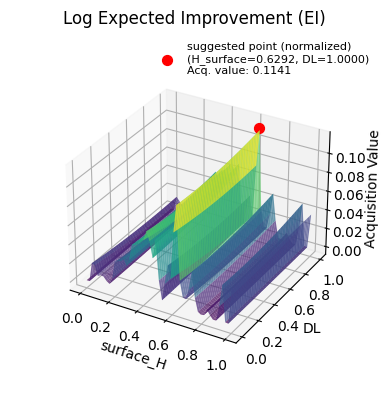

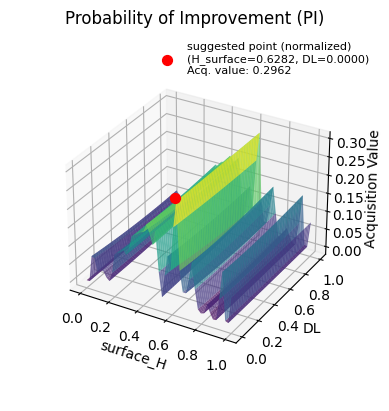

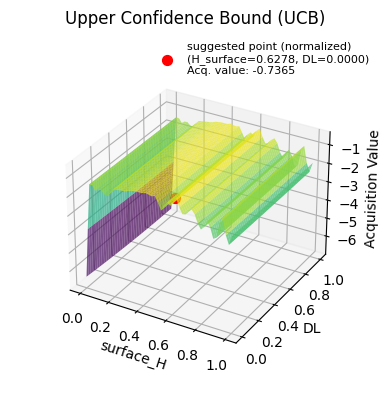

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define two dimensions for plotting (assuming at least 2 dimensions)
dim1, dim2 = 0, 1  # Choose dimensions 0 and 1 for the plot

# Create a grid of points over the normalized bounds in these two dimensions
num_points = 50  # Resolution of the grid
x1 = np.linspace(0, 1, num_points)
x2 = np.linspace(0, 1, num_points)
X1, X2 = np.meshgrid(x1, x2)

# Initialize a tensor of points with all dimensions (other dimensions are fixed at 0.5)
grid_points = torch.full((num_points * num_points, num_params), 0.5, dtype=dtype, device=device)
grid_points[:, dim1] = torch.tensor(X1.ravel(), dtype=dtype, device=device)
grid_points[:, dim2] = torch.tensor(X2.ravel(), dtype=dtype, device=device)

# Evaluate each acquisition function on this grid
def evaluate_acqf(acq_function, grid_points):
    with torch.no_grad():
        # Reshape grid_points to have q=1
        grid_points_reshaped = grid_points.unsqueeze(1)  # Shape: (num_points * num_points, 1, num_params)
        return acq_function(grid_points_reshaped).cpu().numpy().reshape(num_points, num_points)

EI_values = evaluate_acqf(EI_acq, grid_points)
PI_values = evaluate_acqf(PI_acq, grid_points)
UCB_values = evaluate_acqf(UCB_acq, grid_points)

# Define a 3D plotting function
def plot_acqf_3d(X1, X2, Z, title, best_point=None, best_value=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    if best_point is not None:
        formatted_best_point = f"(H_surface={best_point[0]:.4f}, DL={best_point[1]:.4f})"
        ax.scatter(best_point[0], best_point[1], best_value, 
                    color='red', s=50, 
                    label=f'suggested point (normalized)\n{formatted_best_point}\nAcq. value: {best_value:.4f}')
    
    ax.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none', alpha=0.7,
        rstride=1, cstride=1
    )
    ax.set_xlabel(f'surface_H')
    ax.set_ylabel(f'DL')
    ax.set_zlabel('Acquisition Value')
    ax.set_title(title)
    ax.legend(frameon=False, fontsize=8)
    ax.set_box_aspect(aspect=None, zoom=0.8)
    plt.show()

# Plot the acquisition functions
plot_acqf_3d(X1, X2, EI_values, 'Log Expected Improvement (EI)', 
            best_point=EI_suggested_point, best_value=EI_acq_value)
plot_acqf_3d(X1, X2, PI_values, 'Probability of Improvement (PI)', 
            best_point=PI_suggested_point, best_value=PI_acq_value)
plot_acqf_3d(X1, X2, UCB_values, 'Upper Confidence Bound (UCB)', 
            best_point=UCB_suggested_point, best_value=UCB_acq_value)


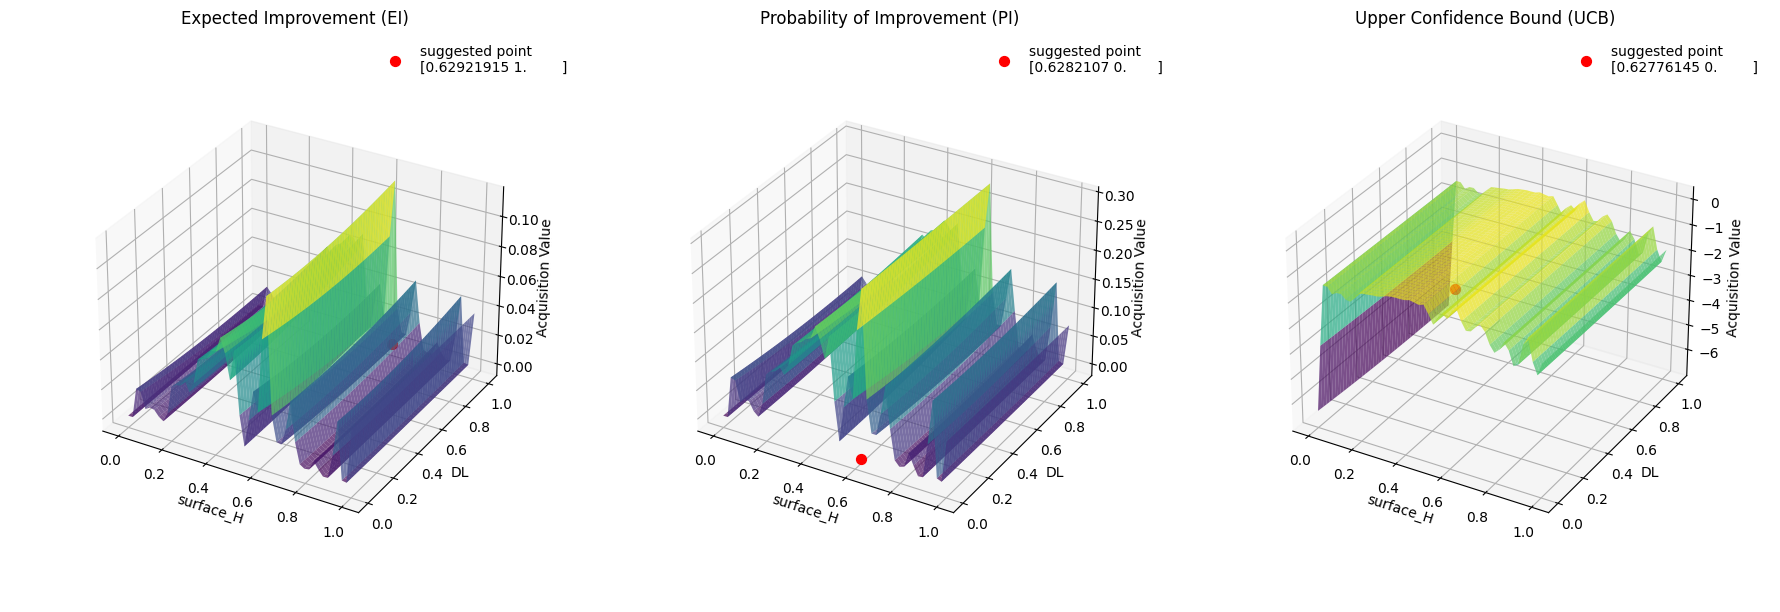

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define two dimensions for plotting (assuming at least 2 dimensions)
dim1, dim2 = 0, 1  # Choose dimensions 0 and 1 for the plot

# Create a grid of points over the normalized bounds in these two dimensions
num_points = 50  # Resolution of the grid
x1 = np.linspace(0, 1, num_points)
x2 = np.linspace(0, 1, num_points)
X1, X2 = np.meshgrid(x1, x2)

# Initialize a tensor of points with all dimensions (other dimensions are fixed at 0.5)
grid_points = torch.full((num_points * num_points, num_params), 0.5, dtype=dtype, device=device)
grid_points[:, dim1] = torch.tensor(X1.ravel(), dtype=dtype, device=device)
grid_points[:, dim2] = torch.tensor(X2.ravel(), dtype=dtype, device=device)

# Evaluate each acquisition function on this grid
def evaluate_acqf(acq_function, grid_points):
    with torch.no_grad():
        # Reshape grid_points to have q=1
        grid_points_reshaped = grid_points.unsqueeze(1)  # Shape: (num_points * num_points, 1, num_params)
        return acq_function(grid_points_reshaped).cpu().numpy().reshape(num_points, num_points)

EI_values = evaluate_acqf(EI_acq, grid_points)
PI_values = evaluate_acqf(PI_acq, grid_points)
UCB_values = evaluate_acqf(UCB_acq, grid_points)

# Define a plotting function with subplots for each acquisition function
def plot_acqf_3d_subplots(X1, X2, EI_Z, PI_Z, UCB_Z, EI_best, PI_best, UCB_best):
    fig = plt.figure(figsize=(18, 6))

    # Plot EI acquisition function
    ax1 = fig.add_subplot(131, projection='3d')

    ax1.plot_surface(X1, X2, EI_Z, cmap='viridis', edgecolor='none', alpha=0.7, rstride=1, cstride=1)
    ax1.scatter(*EI_best, color='red', s=50, label=f'suggested point\n{EI_best}')
    ax1.set_xlabel('surface_H')
    ax1.set_ylabel('DL')
    ax1.set_zlabel('Acquisition Value')
    ax1.set_title('Expected Improvement (EI)', fontsize=12)
    ax1.legend(frameon=False, fontsize=10)
    ax1.set_box_aspect(aspect=None, zoom=0.8)

    # Plot PI acquisition function
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X1, X2, PI_Z, cmap='viridis', edgecolor='none', alpha=0.7, rstride=1, cstride=1)
    ax2.scatter(*PI_best, color='red', s=50, label=f'suggested point\n{PI_best}')
    ax2.set_xlabel('surface_H')
    ax2.set_ylabel('DL')
    ax2.set_zlabel('Acquisition Value')
    ax2.set_title('Probability of Improvement (PI)', fontsize=12)
    ax2.legend(frameon=False, fontsize=10)
    ax2.set_box_aspect(aspect=None, zoom=0.8)

    # Plot UCB acquisition function
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X1, X2, UCB_Z, cmap='viridis', edgecolor='none', alpha=0.7, rstride=1, cstride=1)
    ax3.scatter(*UCB_best, color='red', s=50, label=f'suggested point\n{UCB_best}')
    ax3.set_xlabel('surface_H')
    ax3.set_ylabel('DL')
    ax3.set_zlabel('Acquisition Value')
    ax3.set_title('Upper Confidence Bound (UCB)', fontsize=12)
    ax3.legend(frameon=False, fontsize=10)
    ax3.set_box_aspect(aspect=None, zoom=0.8)

    plt.tight_layout()
    plt.show()

# Plot all three acquisition functions on the same figure
plot_acqf_3d_subplots(X1, X2, EI_values, PI_values, UCB_values, EI_suggested_point, PI_suggested_point, UCB_suggested_point)
